In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [4]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [5]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [6]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Importing in GJ1243 light curve (DR-25)

In [7]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


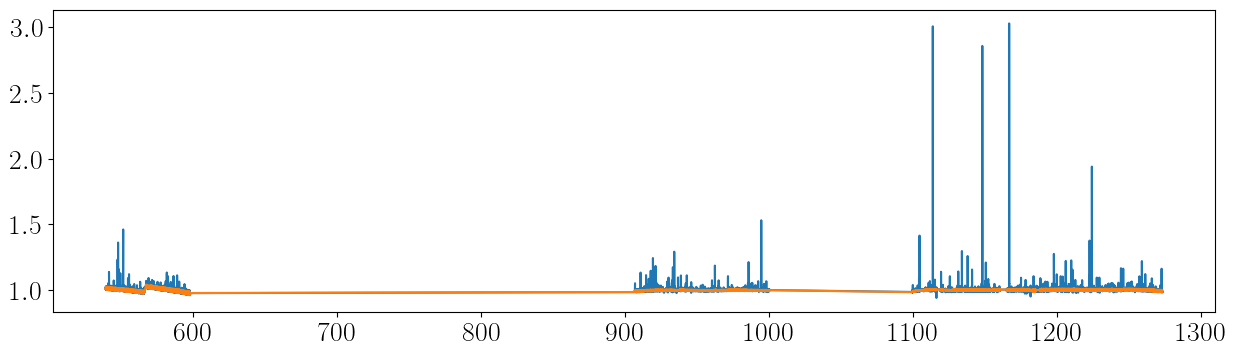

In [8]:
#Reading in the 11 mo gp files
from glob import glob

gp_files = glob('*11mo_*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


In [9]:
print(len(df['df_flux_err']))

453111


In [10]:
#dropping the nans in the table
df = df.dropna()
df = df.reset_index(drop=True)
print(len(df))

453111


Text(0.5, 0, 'Time - 2457000 [BTJD days]')

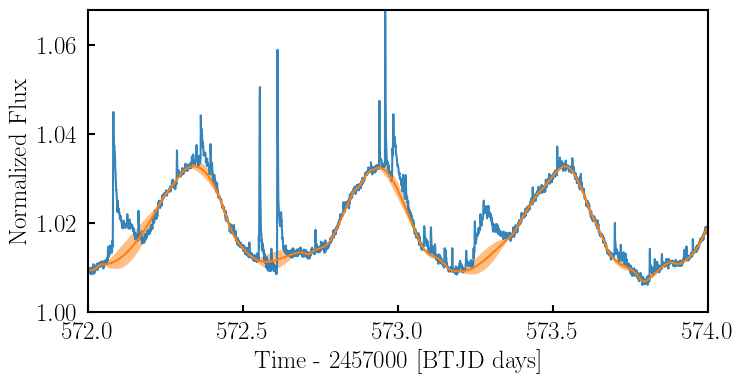

In [11]:

#rcParams["savefig.dpi"] = 300
#rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
#rcParams["figure.figsize"] = [8, 4]
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
#rcParams["text.usetex"] = True

plt.figure(figsize=[8,4])

color = "#ff7f0e"

plt.rcParams['axes.linewidth']=1.5
#plt.rcParams['xtick.major.width'] = 1.5
#plt.rcParams['ytick.major.width'] = 1.5
#plt.rc('xtick.major', size=6, pad=5)
plt.tick_params(direction='in',width=1.5,length=5,pad=7)

plt.xticks(np.arange(572,574.5, step=0.5))


plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color=color, alpha=0.5,
                 edgecolor="none",label='gp')

plt.xlim(572,574)
#plt.xlim(914,916)
plt.ylim(1,1.068)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

#plt.savefig('/Users/lupitatovar/flares/figures/gp_overlay.png',bbox_inches='tight')

#plt.show()

In [12]:
detrended = df['detrended_flux'].values - df['mean'].values
#print(detrended)

### Interpolating over full light curve 

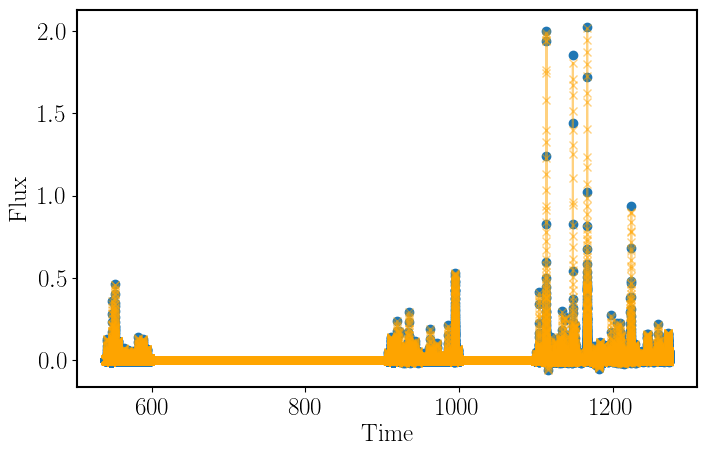

In [34]:
#interpolating the full light curve
plt.scatter(df['time'],detrended)

plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(detrended)

xvals = np.linspace(539.460, 1273.07, steps)
yinterp = np.interp(xvals, df['time'], detrended)
plt.plot(xvals,yinterp,'-x',color='orange',alpha=0.5)

Interpolating over cummulative distribution

Text(0, 0.5, 'Flux')

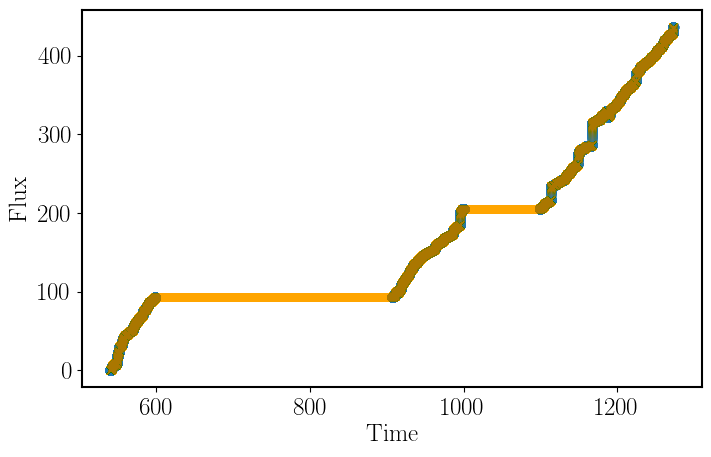

In [26]:

#padding_factor = 10
#steps = padding_factor*len(detrended)
cd_detrended = np.cumsum(detrended)

xvals_cd = np.linspace(539.460, 1273.07, steps)
yinterp_cd = np.interp(xvals_cd, df['time'], cd_detrended)
plt.plot(xvals_cd,yinterp_cd,'-x',color='orange',alpha=0.1)

plt.scatter(df['time'],cd_detrended)

plt.xlabel("Time")
plt.ylabel("Flux")


In [14]:
#timed_classical
classic_start=timed_classical.loc[:,'t_start'].values
classic_stop=timed_classical.loc[:,'t_stop'].values
classic_dur = timed_classical.loc[:,'Flare_Duration'].values
#print(classic_start)

In [27]:
print(len(detrended))
print(len(np.cumsum(detrended)))

453111
453111


In [58]:
print(np.percentile(cd_detrended,50))
print(np.percentile(detrended,50))

211.73496316238075
0.00021172185063522697


#### Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [38]:
''''
time_max = np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(timed_classical)):
    #for interpolated data
    temp1 = np.where((xvals < timed_classical['t_stop'].values[i]) & 
                    (xvals > timed_classical['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    time_max = np.append(time_max,t_max)
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    i_xs = np.where((yinterp[temp1] > half_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)
    flux_fwhm = np.where(yinterp > half_peaks[i])[0]  #fluzes above the fwhm 
    
#####################################################################################    
    #plotting and saving 902 flares 
#####################################################################################    
    
    #plt.figure(figsize=[12,6])
    
    #plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=50)
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    ##plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    ##plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    #plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    #plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    ##plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    #plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    #plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    #plt.title('Flare:'+ str(i))
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()

In [ ]:
#for i in range(0,len(m1_flares_dur_limit)):
    #plt.figure()

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half')
    #plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=30)
    #plt.plot(month1_xvals,month1_yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.scatter(oneflare_x,detrended_unmes,color='red',alpha=0.5,s=10,label='raw data')
    #plt.xlim(m1_flares_dur_limit['t_start'].values[i],m1_flares_dur_limit['t_stop'].values[i])
    #plt.ylim(-.002,m1_flares_dur_limit['flux peak'].values[i]+.005)
    #plt.legend()
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    
    #plt.show()

In [33]:
print(max(detrended))
print(np.max(detrended))
print(xvals)

2.0242919801171078
2.0242919801171078
[ 539.46        539.46016191  539.46032381 ... 1273.06967619 1273.06983809
 1273.07      ]


Trying new stacking technique - the goal is to make the model less sensitive to sampling

We are trying out new ways to avoid having an infinite peak such as using the cummulative distribution of the detrended flux which would give a more robust peak time 

In [48]:
cd_time_max = np.array([])
cd_peaks = np.array([])
cd_t_halfs = np.array([])
for i in range(0,len(timed_classical)):
    #for interpolated data
    temp1 = np.where((xvals < timed_classical['t_stop'].values[i]) & 
                    (xvals > timed_classical['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'] < timed_classical['t_stop'].values[i]) & 
                    (df['time'] > timed_classical['t_start'].values[i]))[0]
    
    cd_detrended = np.cumsum(detrended)
    
    cd_i_max = np.argmax(cd_detrended[temp2])
    t_max = (df['time'].values[temp2][cd_i_max])
    
    cd_flux_max = (cd_detrended[temp2][cd_i_max])
    cd_time_max = np.append(cd_time_max,t_max)
    cd_peaks = np.append(cd_peaks,cd_flux_max)
    cd_half_peaks = cd_peaks/2.0
    
    cd_i_xs = np.where((yinterp_cd[temp1] > cd_half_peaks[i]))[0]
    cd_time_xs = xvals[temp1][cd_i_xs]
    cd_t_half = max(cd_time_xs) - min(cd_time_xs)
    cd_t_halfs = np.append(cd_t_halfs,cd_t_half)
    cd_flux_fwhm = np.where(yinterp_cd > cd_half_peaks[i])[0]  #fluxes above the fwhm 

In [51]:
print(len(cd_t_halfs))
print(len(cd_peaks))
print(len(cd_time_max))
print(len(yinterp_cd))
print(len(xvals))
print(len(cd_flux_fwhm))

902
902
902
4531110
4531110
983993


### Plotting the Stacked Flares

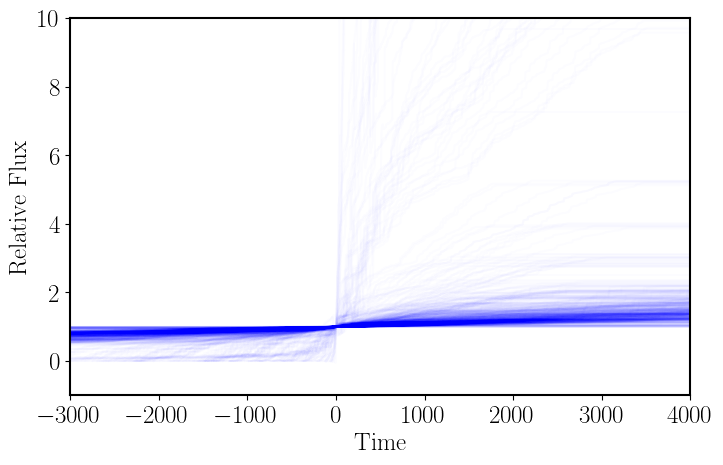

In [54]:
for i in range(0,len(timed_classical)):
        cd_x = (df['time'] - cd_time_max[i])/(cd_t_halfs[i])
        cd_y = ((cd_detrended)/(cd_peaks[i]))
        plt.plot(cd_x,cd_y,color='b',alpha=0.01)


        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-1,10)
        plt.xlim(-3000,4000)
        #plt.ylim(-0.4,1.5)


### Flare Diagnostics on 902 classical flares

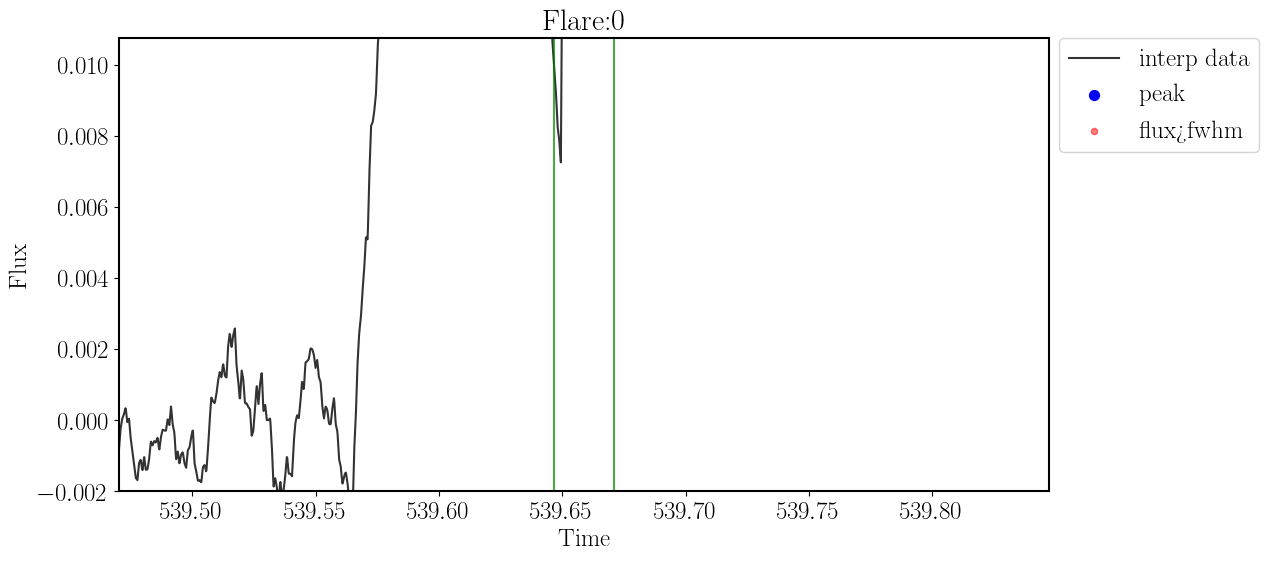

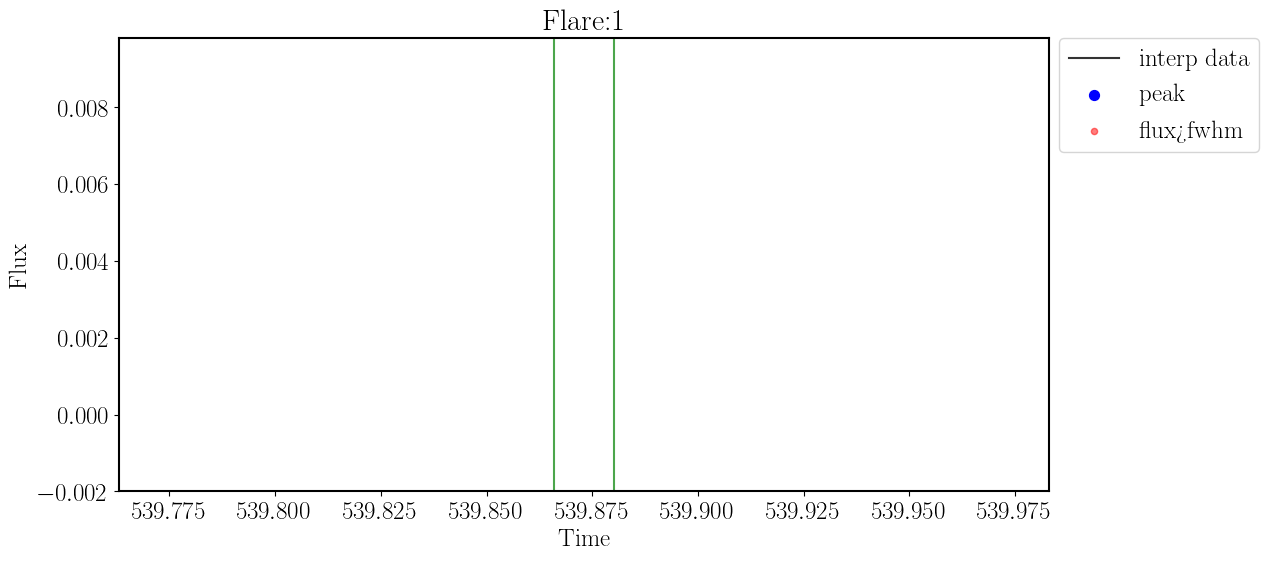

In [56]:
# have the padding be +/- duration = timed_clasical[t_start]-t_stop
#len(timed_classical)

for i in range(0,2):
    plt.figure(figsize=[12,6])
    flux_fwhm = np.where(yinterp_cd > cd_half_peaks[i])[0] 
    
    plt.scatter(cd_time_max[i],cd_peaks[i],color='blue',label='peak',s=50)
    plt.plot(xvals,yinterp_cd,color='black',alpha=0.8,label='interp data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    plt.scatter(xvals[cd_flux_fwhm],yinterp_cd[cd_flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()


In [ ]:
#notebook kept dying so had to split up the flares into two batches
''''
for i in range(533,len(timed_classical)):
    plt.figure(figsize=[12,6])
    flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    plt.scatter(time_max[i],peaks[i],color='blue',label='peak',s=50)
    plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=classic_start[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=classic_stop[i], color='green', linestyle='-',alpha=0.7)
    

    plt.ylim(-.002,timed_classical['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(timed_classical['t_start'].values[i]-.005*classic_dur[i],timed_classical['t_stop'].values[i]+.005*classic_dur[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
    
''''

### Cleaning up the Flare Sample
Flares to use below

In [14]:
new_flares=pd.read_csv('/Users/lupitatovar/flares/notebooks/flare_diagnostics/flare_diagnostics.csv',
            delim_whitespace=True,names=["Flare_Number","Type","Notes"])

In [15]:
flag = pd.to_numeric(new_flares["Type"].values, errors='coerce') #nan = classical , 2= adjust start/stop , 3= remove

In [16]:
# Separating the new set of flares and printing new ammounts of flares

still_classical = len(np.where(np.isnan(flag))[0])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
edit_times = new_flares[new_flares["Type"].values == '2']
toss_flares = new_flares[new_flares["Type"].values == '3']
still_classic_flares = new_flares[pd.isnull(new_flares["Type"].values)]

#includes falres that need start/stop times edited
keep_flares = edit_times.combine_first(still_classic_flares)

The number of remaining classical flares : 476
The number flares tossed out : 341
The number of flares who need edited times : 83


In [17]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
#cross matching the two lists to get new table that has all the flare info!

cross_match = pd.merge(left=timed_classical, right=keep_flares, left_on='Index', right_on='Flare_Number')
cross_match.shape
#cross_match


(558, 20)

In [36]:
new_time_max = np.array([])
new_peaks = np.array([])
new_t_halfs = np.array([])
for i in range(0,len(cross_match)):
    #for interpolated data
    temp1 = np.where((xvals < cross_match['t_stop'].values[i]) & 
                    (xvals > cross_match['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'] < cross_match['t_stop'].values[i]) & 
                    (df['time'] > cross_match['t_start'].values[i]))[0]
    
    
    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    new_time_max = np.append(new_time_max,t_max)
    new_peaks = np.append(new_peaks,flux_max)
    nhalf_peaks = new_peaks/2.0
    i_xs = np.where((yinterp[temp1] > nhalf_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    new_t_halfs = np.append(new_t_halfs,t_half)
    flux_fwhm = np.where(yinterp > nhalf_peaks[i])[0]  #fluxes above the fwhm 

NameError: name 'cross_match' is not defined

In [20]:
print(len(new_peaks))

558


## Stacked flares with newly vetted flare list

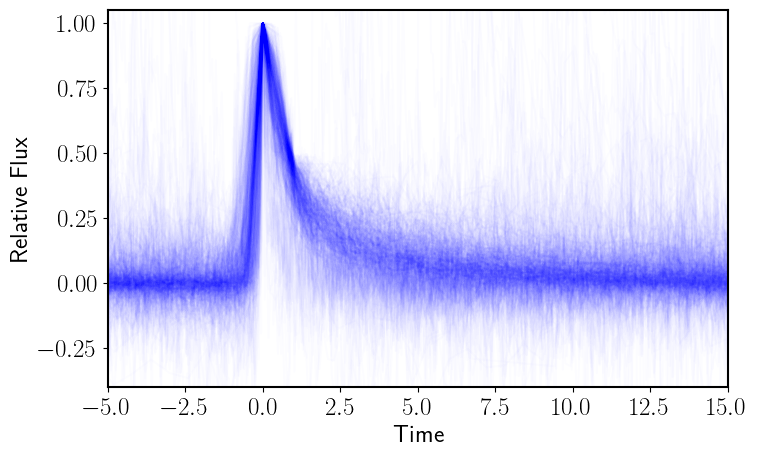

In [21]:
#New stack of flares

for i in range(0,len(cross_match)):
        x_new = (df['time'] - new_time_max[i])/(new_t_halfs[i])
        y_new = ((detrended)/(new_peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.01)


        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)

In [22]:
print(len(timed_classical))
print(len(cross_match))

902
558


In [23]:
toss = pd.merge(left=timed_classical, right=toss_flares, left_on='Index', right_on='Flare_Number')
toss.shape
#toss


(341, 20)

#### Overlaying the GP onto the flares that were tossed out

In [ ]:
''''
toss_start=toss.loc[:,'t_start'].values
toss_stop=toss.loc[:,'t_stop'].values
toss_dur = toss.loc[:,'Flare_Duration'].values

for i in range(0,len(toss)):
    plt.figure(figsize=[12,6])
    flux_fwhm = np.where(yinterp > nhalf_peaks[i])[0] 
    
    plt.scatter(new_time_max[i],new_peaks[i],color='blue',label='peak',s=50)
    plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interpdata')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux$>$fwhm',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=toss_start[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=toss_stop[i], color='green', linestyle='-',alpha=0.7)
    
    
    
    plt.plot(df['time'], df['detrended_flux']-1,color='darkgrey',label='raw data')
    plt.plot(df['time'].values, df['mean'].values-1,color='orange')
    plt.fill_between(df['time'].values, (df['mean'].values-1)+df['std'].values, (df['mean'].values-1)-df['std'].values,
                    color='orange', alpha=0.5,edgecolor="none",label='gp')
    
    #plt.ylim(-.002,toss['flux peak'].values[i]+.005)
    plt.ylim(-.001,.04)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(toss_start[i]-.005*toss_dur[i],toss_stop[i]+.005*toss_dur[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/flares/notebooks/flare_diagnostics/tossed/'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
    #plt.show()

#plt.xlim(1210,1213)
#plt.ylim(.986,1.03)

(-0.01, 0.02)

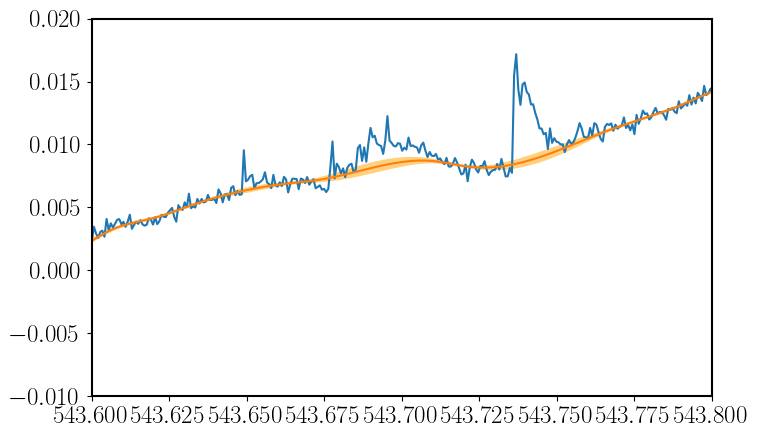

In [24]:
#df['time'].values
plt.plot(df['time'], df['detrended_flux']-1)
plt.plot(df['time'].values, df['mean'].values-1)
plt.fill_between(df['time'].values, (df['mean'].values-1)+df['std'].values, (df['mean'].values-1)-df['std'].values,color='orange', alpha=0.5,edgecolor="none",label='gp')
plt.xlim(543.6,543.8)
plt.ylim(-.01,0.02)

In [25]:
#plt.plot(df['time'].values,detrended)
df['std'].values

array([0.00022359, 0.00020527, 0.0001889 , ..., 0.00018366, 0.00019813,
       0.0002141 ])

### Comparison of DR25 and DR23

In [26]:
#time,flux,err,detrended_flux
dr23 = pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat'
                  ,skiprows=1,delim_whitespace=True,names=['time','flux','error','detrended_flux'])

#dr23



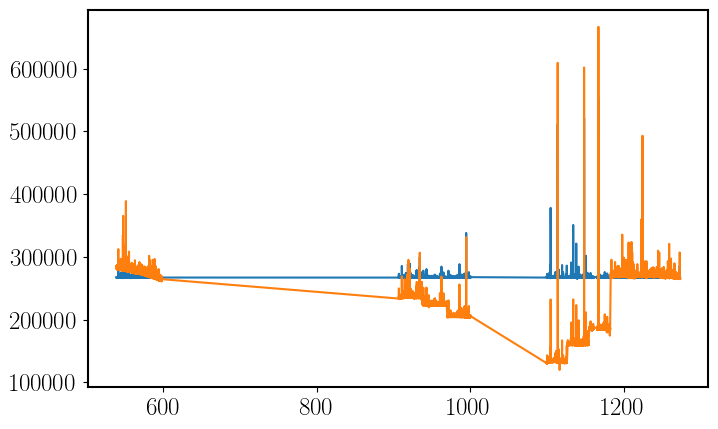

In [27]:
plt.plot(dr23['time'].values,dr23['detrended_flux'].values)
plt.plot(gj1243lc.time,gj1243lc.flux)

### Overplotting Jim's flare model onto this w/ amp=1,t_half=1,peak=0
https://github.com/jradavenport/appaloosa/blob/master/appaloosa/aflare.py

In [28]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

(-5.0, 15.0)

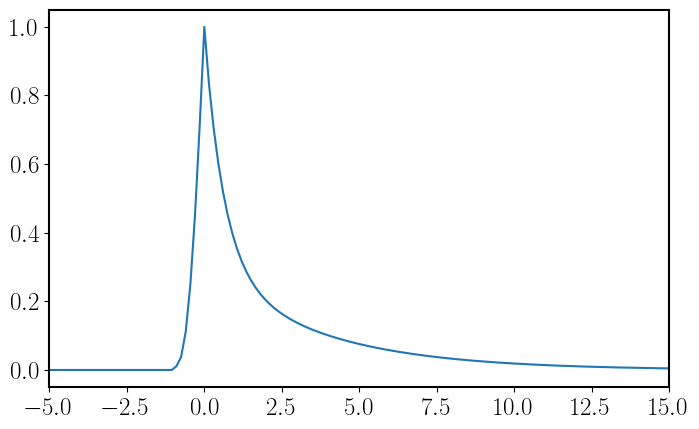

In [29]:
plt.plot(x_new,aflare1(x_new.values,0,1,1))
#plt.plot(x,jim_model,color='red')
plt.xlim(-5,15)

The arrays below contain time, flux, flux_err, and standard deviation for each flare within the ranges of [-5,15]

In [ ]:
x_all=np.array([])
y_all=np.array([])
y_err = np.array([])
gp_st_dev = np.array([])
xmin=-5
xmax=15

for i in range(0,len(timed_classical)):
        x = (df['time'].values - time_max[i])/(t_halfs[i])
        y = ((detrended)/(peaks[i]))
        plt.plot(x,y,color='b',alpha=0.01)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        xs = np.where((x <= xmax) & (x>=xmin))[0]
        x_all = np.append(x_all,x[xs])
        
        #Flux Arrays
        y_all = np.append(y_all,y[xs])
        
        #Flux Errors
        flux_err = df['df_flux_err'].values/peaks[i] 
        y_err = np.append(y_err,flux_err[xs])
        
        #GP Standard Deviation
        st_dev = df['std'].values/peaks[i]
        gp_st_dev = np.append(gp_st_dev,st_dev[xs])
                  
plt.plot(x,aflare1(x,0,1,1),color='red',label='Jims Model')        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


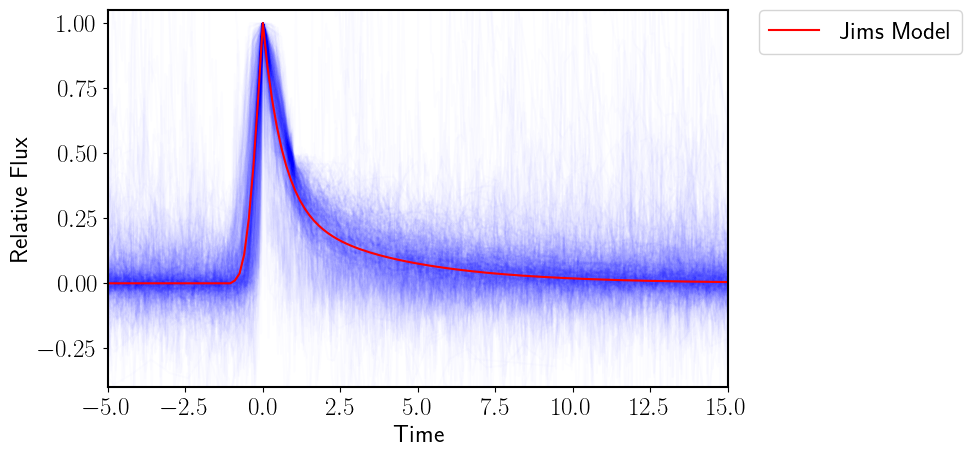

In [30]:
new_x_all=np.array([])
new_y_all=np.array([])
new_y_err = np.array([])
new_gp_st_dev = np.array([])
xmin=-5
xmax=15


for i in range(0,len(cross_match)):
        x_new = (df['time'].values - new_time_max[i])/(new_t_halfs[i])
        y_new = ((detrended)/(new_peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.01)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        nxs = np.where((x_new <= xmax) & (x_new>=xmin))[0]
        new_x_all = np.append(new_x_all,x_new[nxs])
        
        #Flux Arrays
        new_y_all = np.append(new_y_all,y_new[nxs])
        
        #Flux Errors
        new_flux_err = df['df_flux_err'].values/new_peaks[i] 
        new_y_err = np.append(new_y_err,new_flux_err[nxs])
        
        #GP Standard Deviation
        new_st_dev = df['std'].values/new_peaks[i]
        new_gp_st_dev = np.append(new_gp_st_dev,new_st_dev[nxs])
                  
plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [ ]:
#saving the arrays to a file
#dict_i = {'time':x_all,'flux': y_all, 'flux_err': y_err, 'gp_st_dev': gp_st_dev} 
#stacked_flares = pd.DataFrame(data=dict_i) 
#stacked_flares.to_csv(r'stacked_flare_values.csv',header=True,index=True)


#dict_n = {'time':new_x_all,'flux': new_y_all, 'flux_err': new_y_err, 'gp_st_dev': new_gp_st_dev} 
#new_stacked_flares = pd.DataFrame(data=dict_n) 
#new_stacked_flares.to_csv(r'new_stacked_flare_values.csv',header=True,index=True)

In [ ]:
#new_stacked_flare_vals=pd.read_csv('stacked_flare_values.csv')

In [ ]:
s_all = np.argsort(x_all)
jim_model = aflare1(x_all,0,1,1)
plt.scatter(x_all,y_all,alpha=.07,s=10,marker='.')
plt.ylim(-0.4,1.05)
plt.plot(x_all[s_all],jim_model[s_all],color='red')  
plt.xlabel('Time')
plt.ylabel('Relative Flux')

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

Text(0, 0.5, 'Relative Flux')

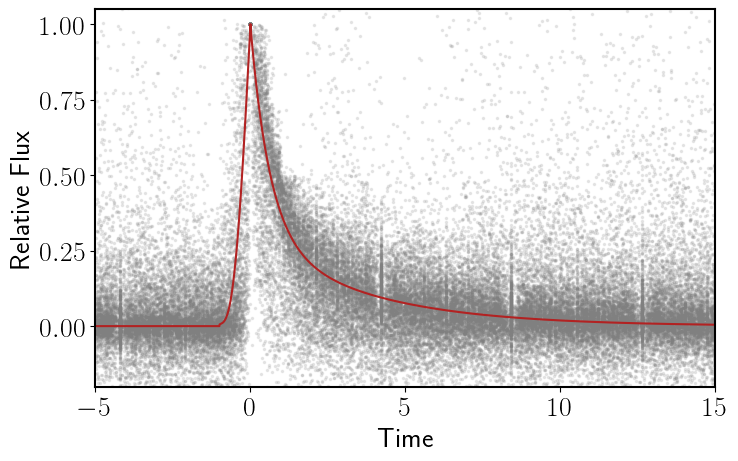

In [31]:
ns_all = np.argsort(new_x_all)
jim_model = aflare1(new_x_all,0,1,1)

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True


plt.scatter(new_x_all,new_y_all,alpha=.15,s=10,marker='.',color='grey')
plt.ylim(-0.2,1.05)
plt.xlim(-5,15)
plt.plot(new_x_all[ns_all],jim_model[ns_all],color='firebrick')  
plt.xlabel('Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/flares/figures/new_stacked_2014fit.png',bbox_inches='tight')

(0.0, 0.2)

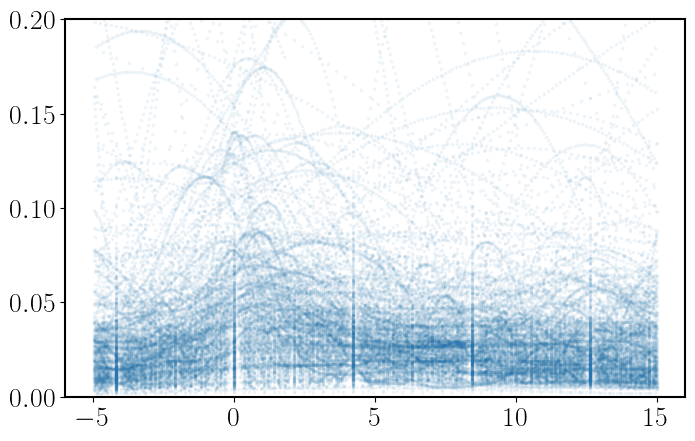

In [32]:
#plot of the gp uncertainty in our detrended data
plt.scatter(new_x_all[ns_all],new_gp_st_dev[ns_all],alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

Below is the flux error from the gp. We expect it to be a straight line centered at zero, however there is some variance between 0-0.3

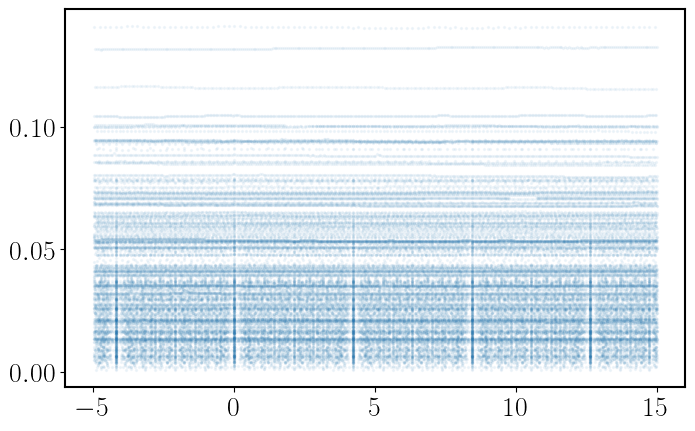

In [33]:
#plot the rolling mean and y_err

plt.scatter(new_x_all[ns_all],new_y_err[ns_all],alpha=.05,s=8,marker='.')
#plt.ylim(0,1)

In [ ]:
#plotting the variance of the st_dev (which is just the st_dev squared?)
plt.scatter(new_x_all,new_gp_st_dev**2,alpha=.05,s=10,marker='.')
plt.ylim(0,.2)

### Fitting the Model

Importing in the new continuous model

In [34]:
'''
Now lets combine the two functions into one continuous analytic flare model

    Parameters (similar as Davenport 2014 aflare1 model)
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    t_0 : float
        The time of the flare peak
    sig/tau : float
        The "Full Width at Half Maximum", timescale of the flare
    A/amp : float
        The amplitude of the flare
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time

'''


Plotting the new model with some arbituary values to show it reads in the time array

Solution to the convolution of a gaussian and a single exponential from Gryciuk et al 2017:https://ui.adsabs.harvard.edu/abs/2017SoPh..292...77G/abstract

In [37]:
from scipy import special
def integral_sol(t,a,b,c,d):
    z = ((2*b + c**2 *d)/(2*c))
    f_t = (1/2) * np.sqrt(np.pi) * a * c * np.exp(d*(b-t) + ((c**2 * d**2)/4))*(special.erf(z) - special.erf(z - (t/c)))
    return f_t

Solution to the convolution of a gaussian and a double exponential: https://en.m.wikipedia.org/wiki/Convolution

In [ ]:
def integral_sol2(t,a,b,c,t01,t02,tau1,tau2,g,f):
    j = (((2*(t-b)*tau2) + c**2)/(2*c*tau2))
    k = (((2*b*tau2) + c**2)/(2*c*tau2))
    m = (((2*(t-b)*tau1) + c**2)/(2*c*tau1))
    n = (((2*b*tau1) - c**2)/(2*c*tau1))
    f_t2 = (1/2) * np.sqrt(np.pi) * a * c * np.exp(-((b*tau2+tau1)/(tau1*tau2))) * ((g*np.exp(((4*b*tau2**2) + (4*t02*tau1*tau2) + (c**2*tau1))/(4*tau1*tau2**2))*(special.erf(j) + special.erf(k)))+ (f*(special.erf(m) + special.erf(n))*np.exp((((4*t01*tau1) + c**2)*(tau2+(4*b*tau1**2))/(4*tau1**2*tau2)))))
    return f_t2

In [39]:
def jackman(t,A,B,C,D1,D2,f1):
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    f_t2 = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    return f_t2

#D1 & D2 - gives the tail slope (influence decay) they are the reciprocals of the exponential power law components
#A&C influence the amplitude
#B shifts left and right (but also affects the rise phase A LOT)
#f1 barely affects the decay slope (have made this number positive and negative and the diffs are minimal)

In [43]:
def gaussian(t,A, t_0, sig):
    return A*np.exp((-(t-t_0)**2) / (2*sig**2))
def double_exp(t,amp1,t_01,tau1,amp2,t_02,tau2):
    return amp1*np.exp((-(t-t_01)/tau1)) + amp2*np.exp((-(t-t_02)/tau2))

def single_exp(t,amp,tau):
    return amp*np.exp(-t/tau)

Comparing the integral result to numpy.convolve result

Modified Gaussian function, meaning the result of convolving a gaussian with an expoential decay that starts at t=0
https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution

In [46]:
def ModifiedGaussian(t,A,mu,sigma,tau):
        x = 1./(2.*tau) * np.exp(.5*(sigma/tau)**2) * np.exp(- (t-mu)/tau)
        s = A*x*( 1. + special.erf((t-mu-sigma**2/tau)/np.sqrt(2*sigma**2)))
        return s

    
def double_exp(t,amp1,t_01,tau1,amp2,t_02,tau2):
    return amp1*np.exp((-(t-t_01)/tau1)) + amp2*np.exp((-(t-t_02)/tau2))
